# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.interpolate import interp1d

## Global Definitions

In [ ]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"
output_dir = "./Output"
model_dir = "./Models"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Set a professional style for the plots
sns.set_theme(style="whitegrid")

model_name = "LSTM"
model_pth_path = f"{model_dir}/best_model_{model_name}.pth"
random.seed(42)

In [3]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1
None
90100
True


### Utilities 

In [4]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_model(model, train_loader, val_loader, attempt_index, epochs=20, lr=1e-3, teacher_forcing_prob=0.5, patience=10):
    """
    Train the given model with validation and return the final validation L1 loss.
    Includes early stopping based on validation loss.
    Logs all metrics (L1, MSE, MAE) for each epoch into a DataFrame.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # Define loss functions
    huberLoss_criterion = nn.HuberLoss()  # Huber Loss
    mse_criterion = nn.MSELoss()  # MSE Loss
    mae_criterion = nn.L1Loss()  # MAE Loss (same as L1 Loss)

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state
    no_improvement_epochs = 0  # Counter for early stopping

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_l1", "train_mse", "train_mae", "val_l1", "val_mse", "val_mae"])

    # Progress bar for epochs
    epochs_pbar = tqdm(range(epochs), desc=f"Trial: {attempt_index}", unit="epoch")

    for epoch in epochs_pbar:
        # Training phase
        model.train()
        running_train_huberLoss_loss = 0.0
        running_train_mse_loss = 0.0
        running_train_mae_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = model(x_batch)

            # Apply teacher forcing
            if random.random() < teacher_forcing_prob:
                x_batch = x_batch.clone()  # Avoid in-place modification
                x_batch[:, -1, 0] = y_batch[:, 0]

            # Calculate loss
            huberLoss_loss = huberLoss_criterion(output, y_batch)
            mse_loss = mse_criterion(output, y_batch)
            mae_loss = mae_criterion(output, y_batch)

            running_train_huberLoss_loss += huberLoss_loss.item()
            running_train_mse_loss += mse_loss.item()
            running_train_mae_loss += mae_loss.item()

            # Backward pass
            optimizer.zero_grad()
            mae_loss.backward()
            optimizer.step()

        avg_train_huberLoss_loss = running_train_huberLoss_loss / len(train_loader)
        avg_train_mse_loss = running_train_mse_loss / len(train_loader)
        avg_train_mae_loss = running_train_mae_loss / len(train_loader)

        # Validation phase
        model.eval()
        running_val_huberLoss_loss = 0.0
        running_val_mse_loss = 0.0
        running_val_mae_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = model(x_batch)

                huberLoss_loss = huberLoss_criterion(output, y_batch)
                mse_loss = mse_criterion(output, y_batch)
                mae_loss = mae_criterion(output, y_batch)

                running_val_huberLoss_loss += huberLoss_loss.item()
                running_val_mse_loss += mse_loss.item()
                running_val_mae_loss += mae_loss.item()

        avg_val_huberLoss_loss = running_val_huberLoss_loss / len(val_loader)
        avg_val_mse_loss = running_val_mse_loss / len(val_loader)
        avg_val_mae_loss = running_val_mae_loss / len(val_loader)

        # Save metrics to DataFrame
        new_row = pd.DataFrame([{
            "trial_id": attempt_index,
            "epoch": epoch + 1,
            "train_HuberLoss": avg_train_huberLoss_loss,
            "train_MSE": avg_train_mse_loss,
            "train_MAE": avg_train_mae_loss,
            "val_HuberLoss": avg_val_huberLoss_loss,
            "val_MSE": avg_val_mse_loss,
            "val_MAE": avg_val_mae_loss
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        # Save the best model
        if avg_val_mae_loss < best_val_loss:
            best_val_loss = avg_val_mae_loss
            best_model_state = model.state_dict()
            no_improvement_epochs = 0  # Reset early stopping counter
        else:
            no_improvement_epochs += 1  # Increment early stopping counter

        # Early stopping
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # Adjust learning rate
        scheduler.step(avg_val_mae_loss)

        # Update progress bar
        epochs_pbar.set_postfix(
            Train_huberLoss_Loss=avg_train_huberLoss_loss,
            Train_MSE_Loss=avg_train_mse_loss,
            Train_MAE_Loss=avg_train_mae_loss,
            Val_huberLoss_Loss=avg_val_huberLoss_loss,
            Val_MSE_Loss=avg_val_mse_loss,
            Val_MAE_Loss=avg_val_mae_loss,
        )

    # Load the best model
    model.load_state_dict(best_model_state)

    return best_val_loss, metrics_df  # Return the best validation L1 loss and metrics DataFrame

### Long short-term memory (LSTM) RNN Model

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout=0.0) :
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True,
                              dropout=dropout if num_stacked_layers > 1 else 0.0)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

### Load and Split the dataset into train-validation

In [6]:
# Define augmentation functions
def add_noise(x, std=0.002):
    return x + np.random.normal(0, std, size=x.shape)

def add_drift(x, strength=0.05):
    drift = np.linspace(0, strength, num=len(x)).reshape(-1, 1)
    return x + drift

def time_warp(x, stretch_factor=1.15):
    original_steps = np.arange(len(x))
    new_steps = np.linspace(0, len(x) - 1, int(len(x) * stretch_factor))
    warped = interp1d(original_steps, x.ravel(), kind='linear', fill_value="extrapolate")(new_steps)
    warped = warped[:len(x)]  # clip/pad to original size
    return warped.reshape(-1, 1)

# Define jittering function
def add_jitter(x, std=0.01):
    """
    Add small random perturbations (jitter) to the data.

    Args:
        x (np.ndarray): Input data.
        std (float): Standard deviation of the jitter.

    Returns:
        np.ndarray: Jittered data.
    """
    return x + np.random.normal(0, std, size=x.shape)

data = loadmat(data_path)
measurements = data['Xtrain']
# Check the shape of the data
print("Shape of measurements:", measurements.shape)

# Display the first few rows of the data
print(f"First 5 measurements: {measurements[:5]}")

print(f"measurements range: min={measurements.min()}, max={measurements.max()}")

# Creating sequences
max_window_size = 50  # Maximum window size
# Split data into training and validation sets
size_of_test = 200 + max_window_size  # 200 steps for testing + window size
train_data, val_data = measurements[:-size_of_test], measurements[-size_of_test:]

# Normalize the training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Normalize the validation data using the same scaler
val_data_normalized = scaler.transform(val_data)

# Augment training data
print(f"Train shape before augmention: {train_data.shape}")

# augmented = [train_data]  # 1x original

# for _ in range(2):  # 2x noise
#     augmented.append(add_noise(train_data))

# for _ in range(2):  # 2x drift
#     augmented.append(add_drift(train_data))

# for _ in range(2):  # 2x time warp
#     augmented.append(time_warp(train_data))

# for _ in range(2):  # 2x jittering
#     augmented.append(add_jitter(train_data))

# train_augmented = np.vstack(augmented)
# print("Augmented shape:", train_augmented.shape)

# Creating sequences
train_dataset, val_dataset = train_data_normalized, val_data_normalized

print(f"Train shape: {train_dataset.shape}, Val shape: {val_dataset.shape}")
print(f"train_dataset range: min={train_dataset.min()}, max={train_dataset.max()}")
print(f"val_dataset range: min={val_dataset.min()}, max={val_dataset.max()}")

Shape of measurements: (1000, 1)
First 5 measurements: [[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]]
measurements range: min=2, max=255
Train shape before augmention: (750, 1)
Train shape: (750, 1), Val shape: (250, 1)
train_dataset range: min=0.0, max=1.0
val_dataset range: min=0.03952569169960474, max=0.6996047430830039


In [7]:
# Plot the train_dataset with different colors for each augmentation type
def plot_augmented_data(train_data, augmented_data, num_augmentations):
    plt.figure(figsize=(30, 6))
    
    # Plot the original data
    plt.plot(train_data, label="Original Data", color="blue", linewidth=2)
    
    # Plot the augmented data
    start_idx = len(train_data)
    for i in range(num_augmentations):
        end_idx = start_idx + len(train_data)
        if i < 2:
            label = f"Noise Augmentation {i + 1}"
            color = "orange"
        # elif i < 4:
        #     label = f"Drift Augmentation {i - 1}"
        #     color = "green"
        # elif i < 6:
        #     label = f"Time Warp Augmentation {i - 3}"
        #     color = "red"
        else:
            label = f"Jittering Augmentation {i - 5}"
            color = "purple"
        plt.plot(range(start_idx, end_idx), augmented_data[start_idx:end_idx], label=label, color=color, linewidth=1)
        start_idx = end_idx

    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Value")
    plt.title("Augmented Training Data")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot the data
# plot_augmented_data(train_data, train_augmented, num_augmentations=2)

### Training the Model 

In [ ]:
best_model = None

# Initialize a global DataFrame to store metrics for all trials
all_metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_HuberLoss", "train_MSE", "train_MAE", "val_HuberLoss", "val_MSE", "val_MAE", 
                                       "hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"])

def objective(trial):
    global all_metrics_df  # Use the global DataFrame to store metrics

    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 128, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    window_size = trial.suggest_int('window_size', 7, 20, step=1)
    # dropout = trial.suggest_float('dropout', 0.0, 0.3, step=0.1) 

    # Update data loaders with the suggested batch size
    train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
    val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)

    # Define the model
    model = LSTM(
        input_size=1,  # Number of features in the input sequence
        hidden_size=hidden_size, # Number of features in the hidden state
        num_stacked_layers=num_layers, # Number of LSTM layers
        # dropout=dropout  # Dropout rate
    ).to(device)

    # Train the model and get the final validation loss and metrics DataFrame
    trial_index = trial.number + 1  # Start from 1 for better readability in logs
    val_loss, metrics_df = train_model(
        model, train_loader, val_loader, attempt_index=trial_index, epochs=100, lr=learning_rate
    )

    # Add trial parameters to the metrics DataFrame
    metrics_df["hidden_size"] = hidden_size
    metrics_df["num_layers"] = num_layers
    metrics_df["learning_rate"] = learning_rate
    metrics_df["batch_size"] = batch_size
    metrics_df["window_size"] = window_size
    # metrics_df["dropout"] = dropout  # Log the dropout value


    # Save the best model
    if trial.number == 0 or val_loss < study.best_value:
        torch.save(model.state_dict(), model_pth_path)
        print(f"Best model saved with trial {trial.number}")
        best_model = model

        # Save the best hyperparameters
        with open(f"{model_dir}/best_hyperparameters_{model_name}.json", "w") as f:
            json.dump({
                "hidden_size": hidden_size,
                "num_layers": num_layers,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "window_size": window_size,
                # "dropout": dropout  
            }, f)

    # Append the metrics for this trial to the global DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

    return val_loss  # Optuna will minimize this


# Create a study object
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Optimize the objective function
study.optimize(objective, n_trials=100)  # Run 100 trials

# Save the combined metrics DataFrame to a CSV file
csv_path = f"{output_dir}/all_trials_metrics_{model_name}.csv"
all_metrics_df.to_csv(csv_path, index=False)
print(f"All metrics saved to {csv_path}")

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Print the best validation loss
print("Best validation loss:", study.best_value)

# Load the best model
best_model = LSTM(
    input_size=1,
    hidden_size=study.best_params['hidden_size'],
    num_stacked_layers=study.best_params['num_layers']
).to(device)
best_model.load_state_dict(torch.load(model_pth_path))
print("Best model loaded.")

# Update train_loader and val_loader with the best hyperparameters
train_loader, train_X, train_y = prepare_dataloader(train_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
val_loader, val_X, val_y = prepare_dataloader(val_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
print("Data loaders updated with best hyperparameters.")

[I 2025-05-08 00:06:09,946] A new study created in memory with name: no-name-70a4ee56-f85f-4fa5-8d1b-8de3624ba6b7


Trial: 1:   0%|          | 0/100 [00:00<?, ?epoch/s]

C:\Users\bar24\AppData\Local\Temp\ipykernel_33700\1617080301.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
[I 2025-05-08 00:06:20,611] Trial 0 finished with value: 0.009483820060268044 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.009909173777312612, 'batch_size': 32, 'window_size': 12}. Best is trial 0 with value: 0.009483820060268044.


Early stopping triggered after 28 epochs.
Best model saved with trial 0


Trial: 2:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:07:04,998] Trial 1 finished with value: 0.01975747151300311 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 4.2892311690166165e-05, 'batch_size': 32, 'window_size': 10}. Best is trial 0 with value: 0.009483820060268044.


Trial: 3:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:07:33,594] Trial 2 finished with value: 0.00477011245675385 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.006172319533162104, 'batch_size': 64, 'window_size': 19}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 94 epochs.
Best model saved with trial 2


Trial: 4:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:07:44,369] Trial 3 finished with value: 0.007170262513682246 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0017161261820365019, 'batch_size': 128, 'window_size': 20}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 56 epochs.


Trial: 5:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:07:50,326] Trial 4 finished with value: 0.13750284537672997 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 1.8005998559254975e-05, 'batch_size': 64, 'window_size': 12}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 21 epochs.


Trial: 6:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:07:57,250] Trial 5 finished with value: 0.009751086588948965 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.004928612746211051, 'batch_size': 64, 'window_size': 11}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 34 epochs.


Trial: 7:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:08:02,970] Trial 6 finished with value: 0.1349207041785121 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.009951266045990797, 'batch_size': 32, 'window_size': 7}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 15 epochs.


Trial: 8:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:08:34,374] Trial 7 finished with value: 0.016123262990731746 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0005609513683555665, 'batch_size': 32, 'window_size': 17}. Best is trial 2 with value: 0.00477011245675385.


Trial: 9:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:08:45,488] Trial 8 finished with value: 0.006817958550527692 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0012310412206489102, 'batch_size': 64, 'window_size': 9}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 46 epochs.


Trial: 10:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:09:22,938] Trial 9 finished with value: 0.014081185450777411 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00017776328834442193, 'batch_size': 32, 'window_size': 19}. Best is trial 2 with value: 0.00477011245675385.


Trial: 11:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:09:29,274] Trial 10 finished with value: 0.050339462235569954 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.00017142063851433798, 'batch_size': 128, 'window_size': 16}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 48 epochs.


Trial: 12:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:09:48,644] Trial 11 finished with value: 0.006251501152291894 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0015783291474035924, 'batch_size': 64, 'window_size': 7}. Best is trial 2 with value: 0.00477011245675385.


Trial: 13:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:09:58,960] Trial 12 finished with value: 0.005692829261533916 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.002583153366359114, 'batch_size': 64, 'window_size': 15}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 48 epochs.


Trial: 14:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:10:14,370] Trial 13 finished with value: 0.005003147991374135 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.004269398902539178, 'batch_size': 64, 'window_size': 15}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 75 epochs.


Trial: 15:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:10:33,026] Trial 14 finished with value: 0.012166999746114016 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0006594107437599199, 'batch_size': 64, 'window_size': 18}. Best is trial 2 with value: 0.00477011245675385.


Trial: 16:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:10:53,531] Trial 15 finished with value: 0.00486385531257838 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.003722444039860955, 'batch_size': 64, 'window_size': 14}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 73 epochs.


Trial: 17:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:11:01,626] Trial 16 finished with value: 0.015466052340343595 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.004605278427156467, 'batch_size': 64, 'window_size': 14}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 28 epochs.


Trial: 18:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:11:11,351] Trial 17 finished with value: 0.007002458907663822 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0003837277855931941, 'batch_size': 128, 'window_size': 20}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 66 epochs.


Trial: 19:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:11:19,589] Trial 18 finished with value: 0.014291321393102407 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.000884412098999252, 'batch_size': 64, 'window_size': 17}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 34 epochs.


Trial: 20:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:11:45,074] Trial 19 finished with value: 0.035964615643024445 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 7.797502339500551e-05, 'batch_size': 64, 'window_size': 13}. Best is trial 2 with value: 0.00477011245675385.


Trial: 21:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:11:52,854] Trial 20 finished with value: 0.006757713854312897 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.003342424500523896, 'batch_size': 128, 'window_size': 18}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 41 epochs.


Trial: 22:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:12:04,202] Trial 21 finished with value: 0.005536122596822679 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0060151937662977694, 'batch_size': 64, 'window_size': 15}. Best is trial 2 with value: 0.00477011245675385.


Early stopping triggered after 55 epochs.


Trial: 23:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:12:25,212] Trial 22 finished with value: 0.00498497043736279 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0027550281322568063, 'batch_size': 64, 'window_size': 14}. Best is trial 2 with value: 0.00477011245675385.


Trial: 24:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:12:46,386] Trial 23 finished with value: 0.00454507558606565 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0020642648431371674, 'batch_size': 64, 'window_size': 13}. Best is trial 23 with value: 0.00454507558606565.


Best model saved with trial 23


Trial: 25:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:13:03,598] Trial 24 finished with value: 0.004718663869425654 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.0022070736747098357, 'batch_size': 64, 'window_size': 9}. Best is trial 23 with value: 0.00454507558606565.


Trial: 26:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:13:21,548] Trial 25 finished with value: 0.005524777807295322 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0018110381075143107, 'batch_size': 64, 'window_size': 9}. Best is trial 23 with value: 0.00454507558606565.


Trial: 27:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:13:39,713] Trial 26 finished with value: 0.0076157262083143 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.000982718666408222, 'batch_size': 64, 'window_size': 9}. Best is trial 23 with value: 0.00454507558606565.


Trial: 28:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:13:58,054] Trial 27 finished with value: 0.004805434495210648 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.007721733359034972, 'batch_size': 64, 'window_size': 11}. Best is trial 23 with value: 0.00454507558606565.


Trial: 29:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:14:05,961] Trial 28 finished with value: 0.03174074366688728 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.00032098172837303064, 'batch_size': 128, 'window_size': 8}. Best is trial 23 with value: 0.00454507558606565.


Early stopping triggered after 79 epochs.


Trial: 30:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:14:15,427] Trial 29 finished with value: 0.005434496211819351 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0024031015848591727, 'batch_size': 64, 'window_size': 12}. Best is trial 23 with value: 0.00454507558606565.


Early stopping triggered after 54 epochs.


Trial: 31:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:14:38,478] Trial 30 finished with value: 0.006234489846974611 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.006502341819371134, 'batch_size': 32, 'window_size': 13}. Best is trial 23 with value: 0.00454507558606565.


Early stopping triggered after 62 epochs.


Trial: 32:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:14:56,377] Trial 31 finished with value: 0.0046372306533157825 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.00867386353032541, 'batch_size': 64, 'window_size': 11}. Best is trial 23 with value: 0.00454507558606565.


Trial: 33:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:15:14,482] Trial 32 finished with value: 0.005247621214948595 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.008117617449130738, 'batch_size': 64, 'window_size': 11}. Best is trial 23 with value: 0.00454507558606565.


Trial: 34:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:15:25,362] Trial 33 finished with value: 0.007989637786522508 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.009505440702966102, 'batch_size': 64, 'window_size': 10}. Best is trial 23 with value: 0.00454507558606565.


Early stopping triggered after 50 epochs.


Trial: 35:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:15:45,522] Trial 34 finished with value: 0.13386428728699684 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 1.005596091567933e-05, 'batch_size': 64, 'window_size': 10}. Best is trial 23 with value: 0.00454507558606565.


Trial: 36:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:15:52,289] Trial 35 finished with value: 0.009854946052655578 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.005433629656383423, 'batch_size': 64, 'window_size': 12}. Best is trial 23 with value: 0.00454507558606565.


Early stopping triggered after 34 epochs.


Trial: 37:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:16:01,274] Trial 36 finished with value: 0.022397136548534036 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0019264132342619077, 'batch_size': 32, 'window_size': 11}. Best is trial 23 with value: 0.00454507558606565.


Early stopping triggered after 27 epochs.


Trial: 38:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:16:09,007] Trial 37 finished with value: 0.008919068844988942 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0012804010529850335, 'batch_size': 64, 'window_size': 8}. Best is trial 23 with value: 0.00454507558606565.


Early stopping triggered after 39 epochs.


Trial: 39:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:16:12,018] Trial 38 finished with value: 0.018114976584911346 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.003288601598762514, 'batch_size': 128, 'window_size': 13}. Best is trial 23 with value: 0.00454507558606565.


Early stopping triggered after 31 epochs.


Trial: 40:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:16:27,600] Trial 39 finished with value: 0.006494787405245006 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0006976930935136226, 'batch_size': 64, 'window_size': 10}. Best is trial 23 with value: 0.00454507558606565.


Early stopping triggered after 78 epochs.


Trial: 41:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:17:04,255] Trial 40 finished with value: 0.03670860966667533 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 4.156006053105473e-05, 'batch_size': 32, 'window_size': 8}. Best is trial 23 with value: 0.00454507558606565.


Trial: 42:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:17:20,186] Trial 41 finished with value: 0.00470281857997179 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0076025047737416545, 'batch_size': 64, 'window_size': 11}. Best is trial 23 with value: 0.00454507558606565.


Trial: 43:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:17:36,293] Trial 42 finished with value: 0.004758768016472459 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.005710804810039366, 'batch_size': 64, 'window_size': 11}. Best is trial 23 with value: 0.00454507558606565.


Trial: 44:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:17:46,915] Trial 43 finished with value: 0.005196020123548806 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.005572275893475125, 'batch_size': 64, 'window_size': 11}. Best is trial 23 with value: 0.00454507558606565.


Early stopping triggered after 59 epochs.


Trial: 45:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:17:57,757] Trial 44 finished with value: 0.00538236740976572 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.009720407128712924, 'batch_size': 64, 'window_size': 12}. Best is trial 23 with value: 0.00454507558606565.


Early stopping triggered after 67 epochs.


Trial: 46:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:18:13,520] Trial 45 finished with value: 0.004111127112992108 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.002236304474215496, 'batch_size': 64, 'window_size': 9}. Best is trial 45 with value: 0.004111127112992108.


Best model saved with trial 45


Trial: 47:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:18:28,461] Trial 46 finished with value: 0.010847740108147264 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0004928368352656472, 'batch_size': 64, 'window_size': 9}. Best is trial 45 with value: 0.004111127112992108.


Trial: 48:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:18:37,791] Trial 47 finished with value: 0.007698638481087983 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.002211960424575907, 'batch_size': 64, 'window_size': 10}. Best is trial 45 with value: 0.004111127112992108.


Early stopping triggered after 59 epochs.


Trial: 49:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:18:52,815] Trial 48 finished with value: 0.020491256145760417 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.00021761860317478965, 'batch_size': 64, 'window_size': 7}. Best is trial 45 with value: 0.004111127112992108.


Trial: 50:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:19:21,901] Trial 49 finished with value: 0.005619408562779427 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.0015056660791389052, 'batch_size': 32, 'window_size': 9}. Best is trial 45 with value: 0.004111127112992108.


Trial: 51:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:19:37,424] Trial 50 finished with value: 0.0057449848391115665 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.004010638894468889, 'batch_size': 64, 'window_size': 8}. Best is trial 45 with value: 0.004111127112992108.


Trial: 52:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:19:51,064] Trial 51 finished with value: 0.004805185832083225 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.006668435884410407, 'batch_size': 64, 'window_size': 10}. Best is trial 45 with value: 0.004111127112992108.


Early stopping triggered after 86 epochs.


Trial: 53:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:20:04,761] Trial 52 finished with value: 0.0042773192981258035 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.004483574816031442, 'batch_size': 64, 'window_size': 11}. Best is trial 45 with value: 0.004111127112992108.


Early stopping triggered after 69 epochs.


Trial: 54:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:20:23,263] Trial 53 finished with value: 0.004677766701206565 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.002971215919611559, 'batch_size': 64, 'window_size': 12}. Best is trial 45 with value: 0.004111127112992108.


Trial: 55:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:20:34,319] Trial 54 finished with value: 0.005588579922914505 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.003484545431034085, 'batch_size': 64, 'window_size': 12}. Best is trial 45 with value: 0.004111127112992108.


Early stopping triggered after 61 epochs.


Trial: 56:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:20:45,527] Trial 55 finished with value: 0.004751608124934137 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.0043626511080705225, 'batch_size': 64, 'window_size': 13}. Best is trial 45 with value: 0.004111127112992108.


Early stopping triggered after 61 epochs.


Trial: 57:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:20:54,775] Trial 56 finished with value: 0.0062735050451010466 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0010410421021745475, 'batch_size': 128, 'window_size': 12}. Best is trial 45 with value: 0.004111127112992108.


Early stopping triggered after 89 epochs.


Trial: 58:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:21:13,270] Trial 57 finished with value: 0.006017360952682793 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0028882244479484765, 'batch_size': 64, 'window_size': 14}. Best is trial 45 with value: 0.004111127112992108.


Trial: 59:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:21:24,950] Trial 58 finished with value: 0.006103124935179949 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.004595382132686797, 'batch_size': 64, 'window_size': 11}. Best is trial 45 with value: 0.004111127112992108.


Early stopping triggered after 59 epochs.


Trial: 60:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:21:28,695] Trial 59 finished with value: 0.024354309542104602 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.00799387361862987, 'batch_size': 64, 'window_size': 13}. Best is trial 45 with value: 0.004111127112992108.


Early stopping triggered after 20 epochs.


Trial: 61:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:21:48,410] Trial 60 finished with value: 0.00539861957076937 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.001456083013786562, 'batch_size': 64, 'window_size': 12}. Best is trial 45 with value: 0.004111127112992108.


Early stopping triggered after 72 epochs.


Trial: 62:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:22:08,132] Trial 61 finished with value: 0.004120565950870514 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.002458549048708504, 'batch_size': 64, 'window_size': 10}. Best is trial 45 with value: 0.004111127112992108.


Trial: 63:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:22:26,748] Trial 62 finished with value: 0.004166380385868251 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0029127281550274287, 'batch_size': 64, 'window_size': 10}. Best is trial 45 with value: 0.004111127112992108.


Trial: 64:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:22:44,071] Trial 63 finished with value: 0.005009547923691571 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.002798155319057876, 'batch_size': 64, 'window_size': 10}. Best is trial 45 with value: 0.004111127112992108.


Trial: 65:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:23:01,810] Trial 64 finished with value: 0.006353951990604401 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.001975757666383883, 'batch_size': 64, 'window_size': 10}. Best is trial 45 with value: 0.004111127112992108.


Trial: 66:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:23:15,554] Trial 65 finished with value: 0.004283160960767418 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.003341810048409057, 'batch_size': 64, 'window_size': 12}. Best is trial 45 with value: 0.004111127112992108.


Early stopping triggered after 79 epochs.


Trial: 67:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:23:23,059] Trial 66 finished with value: 0.009598733391612768 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.0008124341966978957, 'batch_size': 128, 'window_size': 9}. Best is trial 45 with value: 0.004111127112992108.


Early stopping triggered after 80 epochs.


Trial: 68:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:23:35,579] Trial 67 finished with value: 0.004761894349940121 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.0012504370421384347, 'batch_size': 64, 'window_size': 11}. Best is trial 45 with value: 0.004111127112992108.


Early stopping triggered after 73 epochs.


Trial: 69:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:23:53,947] Trial 68 finished with value: 0.0040300830150954425 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0016807081748523584, 'batch_size': 64, 'window_size': 10}. Best is trial 68 with value: 0.0040300830150954425.


Best model saved with trial 68


Trial: 70:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:24:07,978] Trial 69 finished with value: 0.011713697109371424 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.002432055754264433, 'batch_size': 32, 'window_size': 9}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 42 epochs.


Trial: 71:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:24:27,511] Trial 70 finished with value: 0.007190254051238298 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.001109642946875821, 'batch_size': 64, 'window_size': 10}. Best is trial 68 with value: 0.0040300830150954425.


Trial: 72:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:24:36,420] Trial 71 finished with value: 0.00852055917493999 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0016909162320546125, 'batch_size': 64, 'window_size': 11}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 51 epochs.


Trial: 73:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:24:46,336] Trial 72 finished with value: 0.006718895863741636 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.003928175255299406, 'batch_size': 64, 'window_size': 10}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 50 epochs.


Trial: 74:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:24:55,126] Trial 73 finished with value: 0.005335105117410421 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.0048595216246259355, 'batch_size': 64, 'window_size': 9}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 51 epochs.


Trial: 75:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:25:13,081] Trial 74 finished with value: 0.005095012602396309 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.002074386908135657, 'batch_size': 64, 'window_size': 13}. Best is trial 68 with value: 0.0040300830150954425.


Trial: 76:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:25:22,172] Trial 75 finished with value: 0.005410377285443246 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0034627690162338408, 'batch_size': 64, 'window_size': 8}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 53 epochs.


Trial: 77:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:25:36,690] Trial 76 finished with value: 0.004885136964730918 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0016488688114714874, 'batch_size': 64, 'window_size': 11}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 82 epochs.


Trial: 78:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:25:42,566] Trial 77 finished with value: 0.007853054092265666 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0026542405726430766, 'batch_size': 64, 'window_size': 12}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 29 epochs.


Trial: 79:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:25:48,801] Trial 78 finished with value: 0.009324764017947018 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.006350659067758794, 'batch_size': 64, 'window_size': 14}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 36 epochs.


Trial: 80:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:25:58,241] Trial 79 finished with value: 0.00512742786668241 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.003748291844333351, 'batch_size': 128, 'window_size': 15}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 88 epochs.


Trial: 81:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:26:21,780] Trial 80 finished with value: 0.030576316639780998 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 6.0042648526894187e-05, 'batch_size': 64, 'window_size': 10}. Best is trial 68 with value: 0.0040300830150954425.


Trial: 82:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:26:39,780] Trial 81 finished with value: 0.005359778180718422 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0030724879745524128, 'batch_size': 64, 'window_size': 12}. Best is trial 68 with value: 0.0040300830150954425.


Trial: 83:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:26:49,043] Trial 82 finished with value: 0.006274590385146439 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0024023674694502047, 'batch_size': 64, 'window_size': 12}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 52 epochs.


Trial: 84:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:27:01,638] Trial 83 finished with value: 0.004381474631372839 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.004940845078366695, 'batch_size': 64, 'window_size': 11}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 69 epochs.


Trial: 85:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:27:19,558] Trial 84 finished with value: 0.004111761809326708 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.005102907858765465, 'batch_size': 64, 'window_size': 11}. Best is trial 68 with value: 0.0040300830150954425.


Trial: 86:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:27:38,454] Trial 85 finished with value: 0.004821809357963502 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.005017294233083198, 'batch_size': 64, 'window_size': 11}. Best is trial 68 with value: 0.0040300830150954425.


Trial: 87:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:27:52,349] Trial 86 finished with value: 0.008699584694113582 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.007028944784277119, 'batch_size': 32, 'window_size': 10}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 41 epochs.


Trial: 88:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:28:10,047] Trial 87 finished with value: 0.004727859748527408 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0041531137446223195, 'batch_size': 64, 'window_size': 10}. Best is trial 68 with value: 0.0040300830150954425.


Trial: 89:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:28:27,664] Trial 88 finished with value: 0.004376281751319766 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0018233887358322424, 'batch_size': 64, 'window_size': 11}. Best is trial 68 with value: 0.0040300830150954425.


Trial: 90:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:28:44,939] Trial 89 finished with value: 0.005029876017943025 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.001828178430786784, 'batch_size': 64, 'window_size': 11}. Best is trial 68 with value: 0.0040300830150954425.


Trial: 91:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:28:55,304] Trial 90 finished with value: 0.004359101876616478 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.005369407945866665, 'batch_size': 64, 'window_size': 9}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 61 epochs.


Trial: 92:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:29:06,234] Trial 91 finished with value: 0.0048190002562478185 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0050981031316318865, 'batch_size': 64, 'window_size': 9}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 62 epochs.


Trial: 93:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:29:10,594] Trial 92 finished with value: 0.017598886974155903 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0033042700399955553, 'batch_size': 64, 'window_size': 9}. Best is trial 68 with value: 0.0040300830150954425.


Early stopping triggered after 25 epochs.


Trial: 94:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:29:27,731] Trial 93 finished with value: 0.004795787506736815 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.005668405272666986, 'batch_size': 64, 'window_size': 8}. Best is trial 68 with value: 0.0040300830150954425.


Trial: 95:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:29:40,476] Trial 94 finished with value: 0.0038711230736225843 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.002523086139226199, 'batch_size': 64, 'window_size': 10}. Best is trial 94 with value: 0.0038711230736225843.


Early stopping triggered after 69 epochs.
Best model saved with trial 94


Trial: 96:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:29:52,136] Trial 95 finished with value: 0.0059857412707060575 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0014500887859070204, 'batch_size': 64, 'window_size': 10}. Best is trial 94 with value: 0.0038711230736225843.


Early stopping triggered after 66 epochs.


Trial: 97:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:29:57,851] Trial 96 finished with value: 0.012056579580530524 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.002355180896458104, 'batch_size': 64, 'window_size': 9}. Best is trial 94 with value: 0.0038711230736225843.


Early stopping triggered after 32 epochs.


Trial: 98:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:30:15,879] Trial 97 finished with value: 0.00410115480190143 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.003109891068944171, 'batch_size': 64, 'window_size': 10}. Best is trial 94 with value: 0.0038711230736225843.


Trial: 99:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:30:32,070] Trial 98 finished with value: 0.003989206277765334 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0026245565753906944, 'batch_size': 64, 'window_size': 10}. Best is trial 94 with value: 0.0038711230736225843.


Early stopping triggered after 90 epochs.


Trial: 100:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:30:39,231] Trial 99 finished with value: 0.004288241732865572 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0027234514176326307, 'batch_size': 128, 'window_size': 10}. Best is trial 94 with value: 0.0038711230736225843.


Early stopping triggered after 71 epochs.
All metrics saved to all_trials_metrics_LSTM.csv
Best hyperparameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.002523086139226199, 'batch_size': 64, 'window_size': 10}
Best validation loss: 0.0038711230736225843
Best model loaded.
Data loaders updated with best hyperparameters.


C:\Users\bar24\AppData\Local\Temp\ipykernel_33700\1617080301.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_pth_path))


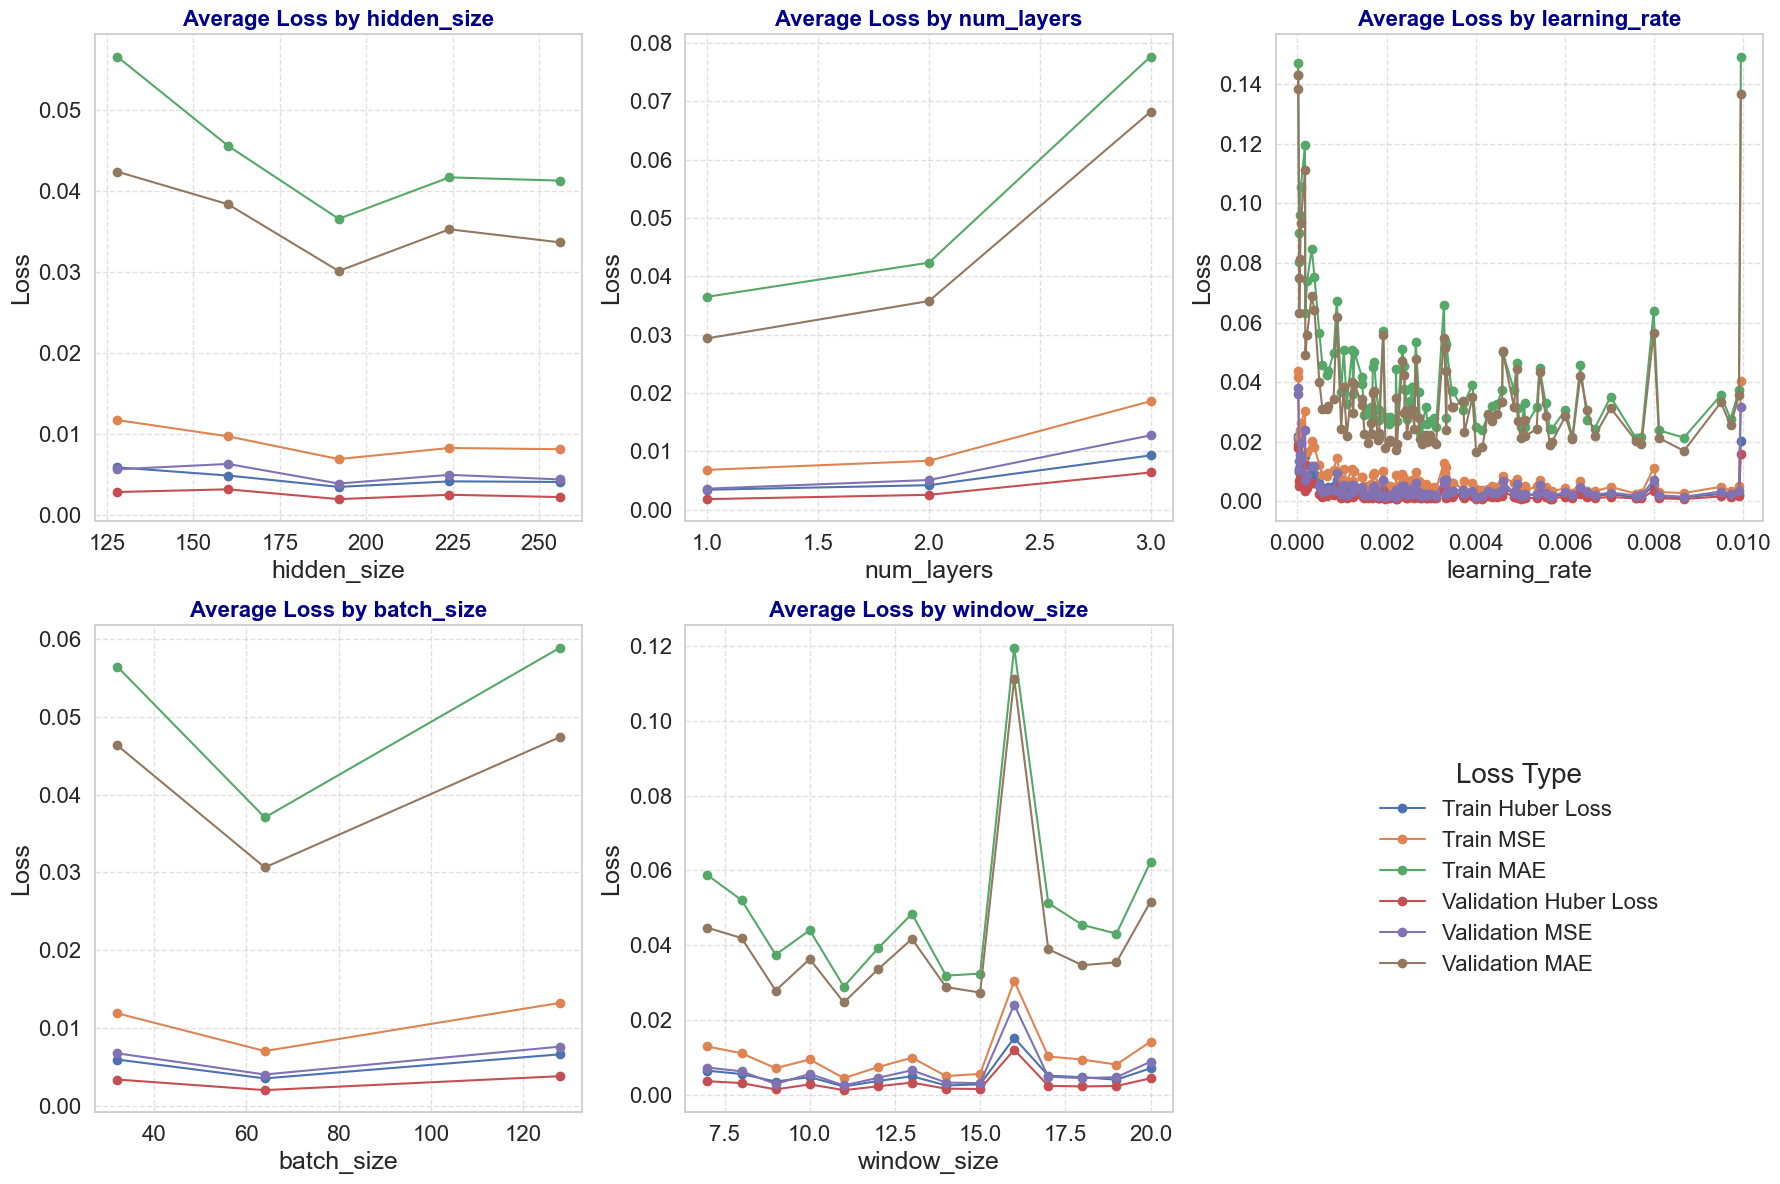

In [ ]:
def plot_metrics_by_parameters(metrics_df, parameters, save_path):
    """
    Create a single figure with subplots for each parameter, showing average losses.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        parameters (list): List of parameters to plot (e.g., ['hidden_size', 'num_layers', 'dropout']).
    """
    # Mapping loss types to more readable names
    loss_type_mapping = {
        "train_HuberLoss": "Train Huber Loss",
        "train_MSE": "Train MSE",
        "train_MAE": "Train MAE",
        "val_HuberLoss": "Validation Huber Loss",
        "val_MSE": "Validation MSE",
        "val_MAE": "Validation MAE"
    }

    num_params = len(parameters)
    ncols = 3  # Number of columns
    nrows = (num_params + ncols - 1) // ncols  # Dynamically calculate rows based on parameters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        grouped = metrics_df.groupby(parameter).mean()  # Group by the parameter and calculate averages
        for loss, readable_name in loss_type_mapping.items():
            if loss in grouped.columns:
                ax.plot(grouped.index, grouped[loss], label=readable_name, marker='o', linestyle='-', linewidth=1.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18)
        ax.set_ylabel("Loss", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(f"Average Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        if j == len(parameters):  # Use the first unused subplot for the legend
            handles, labels = ax.get_legend_handles_labels()
            axes[j].legend(
                handles, labels, loc="center", fontsize=16, title="Loss Type", title_fontsize=20, frameon=False
            )
            axes[j].set_axis_off()  # Turn off the axis for the legend plot
        else:
            fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example: Plot average losses for all parameters in one figure
parameters_to_plot = ["hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"]#, "dropout"]
plot_metrics_by_parameters(all_metrics_df, parameters_to_plot, f"{output_dir}/metrics_by_parameters_{model_name}.png")

### Predict the next 200 data points recursively

C:\Users\bar24\AppData\Local\Temp\ipykernel_33700\2125674564.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)


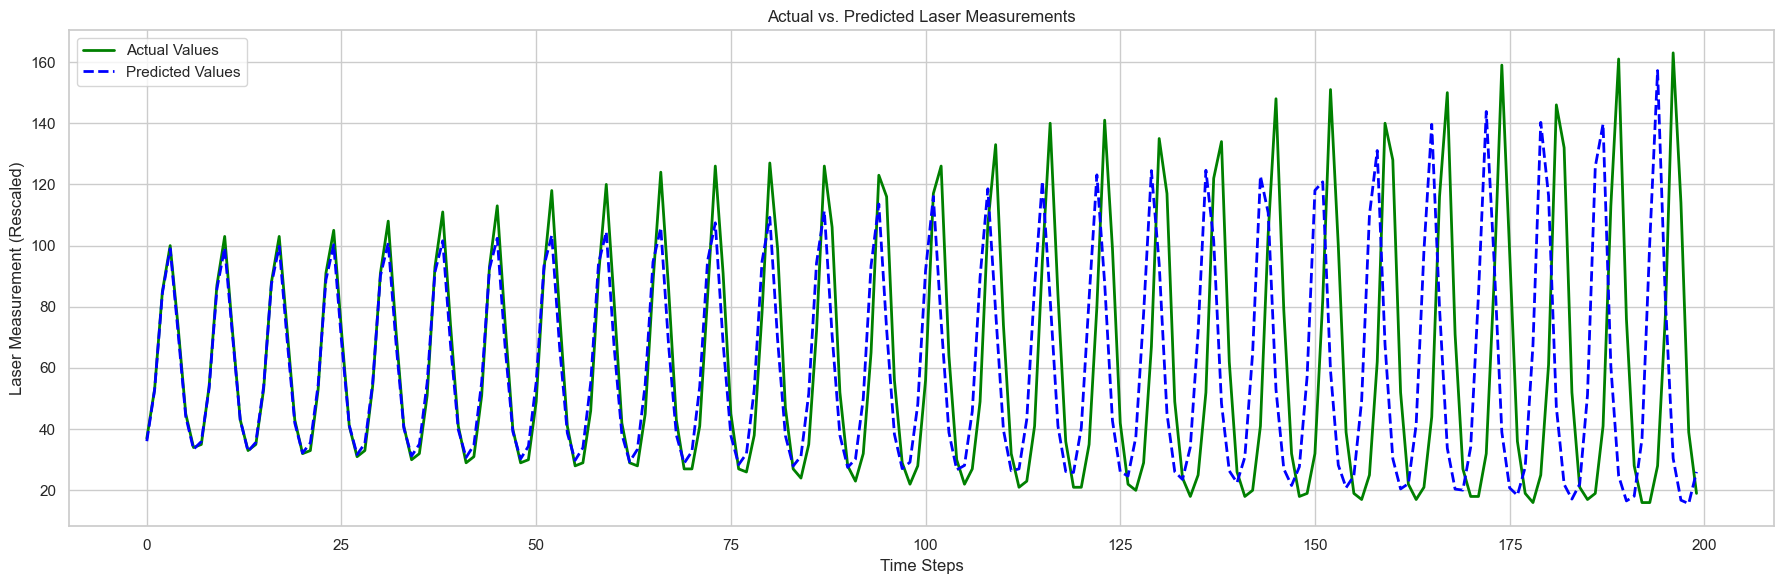

Metrics plot saved to actual_vs_predicted_plot_LSTM.png


In [10]:
def predict_and_inverse_transform(model, init_window, scaler, steps=200):
    """
    Perform recursive forecasting using the trained model and convert predictions back to the original range.

    Args:
        model: The trained LSTM model.
        init_window: The initial sequence window (tensor) in normalized form.
        scaler: The MinMaxScaler used for normalization.
        steps: Number of forecasting steps.

    Returns:
        np.array: Forecasted values in the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            input = current_seq.unsqueeze(0).contiguous()  # Add batch dimension
            pred = model(input)  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred.item()  # Extract the first step of the forecast
            preds.append(pred_value)

            # Update the sequence by appending the prediction and removing the oldest value
            next_value = torch.tensor([[pred_value]], dtype=torch.float32, device=device)
            current_seq = torch.cat((current_seq[1:], next_value), dim=0)

    # Convert predictions to numpy array
    preds = np.array(preds).reshape(-1, 1)

    # Inverse transform the predictions to the original range
    preds_original = scaler.inverse_transform(preds)

    return preds_original

def plot_signals(predictions_rescaled, actual_values, save_path):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Plot Actual vs Predicted Values
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title("Actual vs. Predicted Laser Measurements")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")
   
# Perform recursive forecasting to generate predictions
# Use the first sequence from the validation set as the initial window
init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)

# Predict and convert back to the original range
predicted_signal = predict_and_inverse_transform(best_model, init_window, scaler, steps=200)

# Compare with the actual values (also inverse transformed if needed)
actual_signal = scaler.inverse_transform(val_y[:len(predicted_signal)])

plot_signals(predicted_signal, actual_signal, f"{output_dir}/actual_vs_predicted_plot_{model_name}.png")

In [11]:
import torch.nn as nn

def evaluate_model_on_validation(best_model, val_loader):
    """
    Evaluate the best model on the validation dataset and calculate MSE and MAE using PyTorch loss functions.

    Args:
        best_model: The trained model.
        val_loader: The validation dataset (normalized).

    Returns:
        mse: Mean Squared Error.
        mae: Mean Absolute Error.
    """
    # Switch the model to evaluation mode
    best_model.eval()

    # Define PyTorch loss functions
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    # Collect predictions and ground truth
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = best_model(x_batch)

            # Calculate losses
            mse = mse_criterion(output, y_batch).item()
            mae = mae_criterion(output, y_batch).item()

            # Accumulate losses
            total_mse += mse * x_batch.size(0)
            total_mae += mae * x_batch.size(0)
            num_samples += x_batch.size(0)

    # Calculate average losses
    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    print(f"Validation MSE: {avg_mse}")
    print(f"Validation MAE: {avg_mae}")

    return avg_mse, avg_mae

# Evaluate the best model
mse, mae = evaluate_model_on_validation(best_model, val_loader)

Validation MSE: 2.715382045911004e-05
Validation MAE: 0.004192376509308815


### Load the trained model

In [ ]:
import json

def load_best_model():
    # Load the best hyperparameters
    with open(f"{model_dir}/best_hyperparameters_{model_name}.json", "r") as f:
        best_params = json.load(f)

    # Recreate the model with the best hyperparameters
    best_model = LSTM(
        input_size=1,
        hidden_size=best_params["hidden_size"],
        num_stacked_layers=best_params["num_layers"]
    ).to(device)

    # Load the saved model weights
    best_model.load_state_dict(torch.load(model_pth_path))
    best_model.eval()

    return best_model, best_params

best_model, best_params = load_best_model()
print("Best hyperparameters are:", best_params)